# Homework 9

In this homework, you will be using a form of attention called *attention pooling* to solve the "addition problem". The addition problem was introduced in the [LSTM paper](https://www.bioinf.jku.at/publications/older/2604.pdf) as a way to test whether an RNN could propagate information across many time steps. In the addition problem, the model is given a sequence of 2D vectors in the format:

|     |      |     |     |      |     |      |     |     |     |     |
|-----|------|-----|-----|------|-----|------|-----|-----|-----|-----|
| 0.5 | -0.7 | 0.3 | 0.1 | -0.2 | ... | -0.5 | 0.9 | ... | 0.8 | 0.2 |
| 0   |   0  |  1  |  0  |   0  |     |   0  |  1  |     |  0  |  0  |

The first dimension of each vector in the sequence is a random number between 0 and 1. The second dimension is 0 for all entries of the sequence expect for 2, where it is 1. The goal of the addition problem is to output the sum of the values in the first dimension at the two indices where the second dimension is 1. In the example above, the target would be 0.9 + 0.3 = 1.2. Below is a code snippet that generates a sequence and its target for the addition problem.

In [13]:
import numpy as np

def addition_problem(sequence_length=50):
    output = np.random.uniform(-1, 1, (sequence_length, 2))
    output[:, 0] = 0.
    random_indices = np.random.choice(sequence_length, size=2, replace=False)
    output[random_indices, [0, 0]] = 1
    return output, (output[:, 0]*output[:, 1]).sum(keepdims=True)

Attention pooling is a form of attention that allows a model to solve the addition problem without using an RNN. In attention pooling, the query vector $q$ is a *learnable parameter*. The keys and values are both the input sequence. Specifically, given a sequence $\{h_1, h_2, \ldots, h_T\}$, attention pooling computes
\begin{align}
e_t &= \mathrm{a}(q, h_t) \\
\alpha_t &= \frac{\exp(e_t)}{\sum_k \exp(e_k)} \\
c &= \sum_{t = 1}^T \alpha_t h_t
\end{align}
where $\mathrm{a}(q, h_t)$ is the attention energy function. Note that c will always be a fixed-length vector (which amounts to a weighted average of the elements of the sequence $h$) regardless of how long the sequence is (i.e. the value of $T$). $\mathrm{a}(q, h_t)$ can be any function that takes in a single entry of the sequence $h_t$ and outputs an unnormalizes scalar value. One option is to use
$$\mathrm{a}(q, h_t) = q^\top \tanh(W_a h_t + b_a)$$
where $q \in \mathbb{R}^q$, $W_a \in \mathbb{R}^{q \times d}$, and $b_a \in \mathbb{R}^q$ are learnable parameters, and $d$ is the dimensionality of $h_t$ (i.e. $h_t \in \mathbb{R}^d$).


1. Build and train a neural network that uses attention pooling to solve the addition problem. The model should output a scalar which corresponds to the target value for the addition problem (i.e. the sum of the sequence entries that are marked with a "1"). Here, "solved" means that the squared error of the model's predicitons is always below $0.05$. Use a sequence length of $50$ (which is the default for the `addition_problem` function defined above). *Hints*:
  1. This is a regression problem. Your model should predict a continuous scalar value and you can use a squared-error loss.
  1. The point of the attention pooling layer is to allow you to put it in an otherwise feed-forward network. So, consider just using simple dense feed-forward layers before and/or after the attention pooling layer. To start, you can try the architecture: feed-forward, attention pooling, feed-forward, output layer.
  1. If you are finding that the model is getting stuck at a non-zero squared error, it could be that it's just outputting the mean value and having trouble learning a good solution. Try different initialization, nonlinearities, architecture, learning rate, etc.
1. Once you have trained a model that gets solid performance at sequence length $50$, plot the model's average squared error for sequence lengths $50, 55, 65, 80, 100, 125, 150$. You should generate this plot by averaging the squared error over at least $100$ sequences of a given length. Does the model's error get worse (go up) for longer sequences, or does it generalize to longer sequence lengths?

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim, query_dim):
        super().__init__()
        self.query = nn.Parameter(torch.randn(query_dim, 1))
        self.linear = nn.Linear(hidden_dim, query_dim)

    def forward(self, x):
        linear_out = self.linear(x)
        tanh_out = torch.tanh(linear_out) 
        energy = torch.matmul(tanh_out, self.query) 
        attn_weights = F.softmax(energy, dim=0) 
        context = torch.matmul(x.T, attn_weights)
        return torch.reshape(context, (-1,))

class AdditionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.attention = AttentionPooling(hidden_dim, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        attended_features = self.attention(x)
        attended_features = F.relu(self.fc2(attended_features))
        attended_features = self.output_layer(attended_features)
        return attended_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AdditionModel(input_dim=2, hidden_dim =16 , output_dim = 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2000):
    optimizer.zero_grad()

    input, target = addition_problem(sequence_length=100)
    input, target = torch.from_numpy(input.astype(np.float32)).to(device), torch.from_numpy(target.astype(np.float32)).to(device)

    output = model(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.12790822982788086
Epoch 1, Loss: 0.025009561330080032
Epoch 2, Loss: 0.04075971245765686
Epoch 3, Loss: 1.31000554561615
Epoch 4, Loss: 0.00015726532728876919
Epoch 5, Loss: 0.8343806862831116
Epoch 6, Loss: 0.497293621301651
Epoch 7, Loss: 1.0720895528793335
Epoch 8, Loss: 0.0013354445109143853
Epoch 9, Loss: 2.566612482070923
Epoch 10, Loss: 0.3875979781150818
Epoch 11, Loss: 0.3057669699192047
Epoch 12, Loss: 0.011751714162528515
Epoch 13, Loss: 0.1554359346628189
Epoch 14, Loss: 0.07092652469873428
Epoch 15, Loss: 1.3770053386688232
Epoch 16, Loss: 1.1572809219360352
Epoch 17, Loss: 0.002201078226789832
Epoch 18, Loss: 2.0696256160736084
Epoch 19, Loss: 0.05486757308244705
Epoch 20, Loss: 0.008959055878221989
Epoch 21, Loss: 0.0026104608550667763
Epoch 22, Loss: 2.473177671432495
Epoch 23, Loss: 0.06714601069688797
Epoch 24, Loss: 1.5585230588912964
Epoch 25, Loss: 0.0025258497335016727
Epoch 26, Loss: 0.005327356513589621
Epoch 27, Loss: 2.35305118560791
Epoch 28,

In [46]:
perf = []
with torch.no_grad():
    err = 0
    for seq_len in [50,55,65,80,100,125,150]:
        for _ in range(1000):
            input, target = addition_problem(sequence_length=seq_len)
            input, target = torch.from_numpy(input.astype(np.float32)).to(device), torch.from_numpy(target.astype(np.float32)).to(device)
            pred = model(input)

            err += (pred-target)**2
        perf.append(err.detach().cpu().numpy()/1000)    

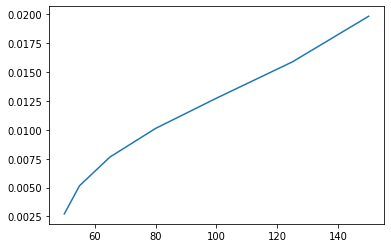

In [47]:
from matplotlib import pyplot as plt
Y = [v[0] for v in perf]
X = [50,55,65,80,100,125,150]
plt.plot(X, Y)